In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from utils import name_generator
import scipy.stats as stats
import pymc as pm
import arviz as az
import corner

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def plot_all_individual_judgements(expert_groups):
    """
    Plots the individual judgements of multiple expert groups on the same histogram for each proposition.

    Parameters:
    - expert_groups: A list of Expert_Group instances.
    """
    if not expert_groups:
        print("No expert groups provided.")
        return
    
    # Define a list of colors or use a colormap
    colors = sns.color_palette('hsv', len(expert_groups))

    # Assuming all expert groups have the same propositions
    propositions = list(expert_groups[0].propositions)
    n_props = len(propositions)
    plt.figure(figsize=(14, 4 * n_props + 2))

    for i, prop in enumerate(propositions, start=1):
        plt.subplot(n_props, 1, i)
        for idx, expert_group in enumerate(expert_groups):
            # Use the same color for individual judgements and aggregate judgement line of the expert group
            group_color = colors[idx]
            label = f'(Bias: {expert_group.population_bias}, population sd: {expert_group.population_sd:.3f}, sample mean sd: {expert_group.sample_mean_sd:.3f}, sample sd: {expert_group.sample_sd_dict[prop]:.3f})'
            #label = f'{expert_group.name} (Bias: {expert_group.bias}, Consensus: {expert_group.consensus}, Competence: {expert_group.competence})'
            sns.histplot(expert_group.individual_judgements[prop], kde=False, bins='auto', color=group_color, label=label, stat="density")
            plt.axvline(x=expert_group.aggregate_judgements[prop], color=group_color, linestyle='--', label=f'{expert_group.name} aggregate judgement')
        
        # Ideal credence line
        plt.axvline(x=expert_groups[0].ideal_credences[prop], color='black', linestyle='--', label=f'Ideal credence for "{prop}"')
        plt.legend()
        plt.title(f'Individual Judgements Distribution for "{prop}"')
        plt.xlabel('Value')
        plt.xlim(0,1)
        plt.ylim(0,15)
        plt.ylabel('Density')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2, title='')
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

In [3]:
''' not sure if i need this. 
Might be helpful in simulating how to maximize accuracy. 
Accuracy is a relation between a credence and the truth.

"There are many different measures of accuracy that can be used; in this paper I will be assuming the
most standardly used measure, the Brier score, but as far as I am aware, assuming a different accuracy 
measure would not necessarily impact the argument." - https://link.springer.com/article/10.1007/s11229-020-02849-z
'''
class World():
    '''maps propositions to truth values'''
    def __init__(self) -> None:
        pass

In [4]:
class Ideal_Credences():
    ''' 
    Maps propositions to credences

    truth of a proposition is binary but ideal credence can range from 0 to 1. 
    Ideal credence is the credence that best fulfills epistemic norms given all 
    available evidence (not necessarily accessible to you).

    "I will assume that credences are sharp and
    that the uniqueness thesis is true (Elga 2010; Kopec & Titelbaum 2016). In other
    words, I will assume that for any proposition p and any set of evidence E there is
    only one maximally rational credence that a perfectly rational epistemic agent could
    have, which is a sharp value and not an interval, and any deviation from the unique
    maximally rational credence constitutes a deviation from rationality."
     - https://link.springer.com/article/10.1007/s11229-020-02849-z
    '''
    def __init__(self, propositions: list, seed = None) -> None:
        if seed is not None:
            random.seed(seed)
        self.credence_function = {}
        self.propositions = propositions
        

    def random_generate_ideal_credences(self):
        self.credence_function = {proposition: random.uniform(0, 1) for proposition in self.propositions}
        


In [5]:
class Expert_Group():
    '''
    Experts are represented at the group level, questions of belief merging and aggregation 
    within the group are abstracted. individual experts are simulated for fun.

    Expert groups are static in this model. Their credences do not update

    Expert groups are defined relative to an ideal credence function (since the attribute "bias" is relative to ideal credence)
    '''
    def __init__(self, ideal_credence_obj:Ideal_Credences, name = None, n_experts:int = 100, population_sd:float = 0.2, population_bias:float = 0.1, population_simulation_n:int = 1000000, simulate = True, plot = False) -> None:
        if name is not None:
            self.name = name
        else:
            self.name = name_generator()
        # simulation settings
        self.n_experts = n_experts
        self.population_simulation_n = population_simulation_n
        # each expert population is defined by two attributes: bias, which is relative to an ideal credence, and population_sd, 
        #which is the standard deviation of the opinions among thepopulation
        self.population_bias = population_bias
        self.population_sd = population_sd
        # get standard deviation of sample mean using central limit theorem
        self.sample_mean_sd = self.population_sd / np.sqrt(self.n_experts)
        # get sample standard deviation

        self.ideal_credences = ideal_credence_obj.credence_function
        self.propositions = list(self.ideal_credences.keys())
        # each expert group has a set of aggregate judgements, which are functions that map credences to propositions
        self.aggregate_judgements = {} 
        self.sample_sd_dict = {}
        self.individual_judgements = {}
        # run init methods
        if simulate:
            self.simulate_expert_population()
            self.simulate_expert_individual_judgements()
            self.get_aggregate_judgements()
        if plot: 
            self.plot_individual_judgements()
            self.plot_expert_sample_mean_distribution()
    
    def simulate_expert_population(self):
        # note that this is not the actual expert population, but a stand in for an infinite pool of counterfactual experts
        # get population mean judgements
        keys = self.propositions
        values = np.array(list(self.ideal_credences.values()))
        # randomly generate a single sample mean using the sample_mean_sd centered around bias + ideal credence
        self.population_means = {prop:value for prop, value in zip(keys, self.population_bias + values)}
        self.expert_population_judgements = {prop: np.clip(np.random.normal(loc=val, scale=self.population_sd, size=self.population_simulation_n), 0, 1)
                   for prop, val in zip(keys, self.population_means.values())}
    
    def simulate_expert_individual_judgements(self, plot = False):
        # randomly select n_experts_sample experts from self.expert_population_judgements, which is a dictionary of arrays
        self.individual_judgements = {
                                        key: np.random.choice(val, size=self.n_experts, replace=False)
                                        for key, val in self.expert_population_judgements.items()
                                    }
        self.sample_sd_dict = {key: np.std(val) for key, val in self.individual_judgements.items()}
        if plot:
            self.plot_individual_judgements()

    def get_aggregate_judgements(self):
        # for each proposition, get the mean of the sampled expert judgements
        self.aggregate_judgements = {key: np.mean(val) for key, val in self.individual_judgements.items()}

    def plot_individual_judgements(self):
        """
        Plots the samples for each proposition in self.aggregate_judgements.
        Each proposition's samples are plotted as a histogram.
        """
        n_props = len(self.propositions)   
        plt.figure(figsize=(12, 3 * n_props))

        for i, (prop, values) in enumerate(self.individual_judgements.items(), start=1):
            label = f'{self.name} (Bias: {self.population_bias}, population sd: {self.population_sd:.3f}, sample mean sd: {self.sample_mean_sd:.3f}, sample_sd = {self.sample_sd_dict[prop]:.3f})'
            plt.subplot(n_props, 1, i)
            sns.histplot(values, kde=False, bins='auto', color='skyblue', label=label, stat="density")
            plt.axvline(x=self.aggregate_judgements[prop], color='b', linestyle='--', label=f'Aggregate judgement')
            plt.axvline(x=self.ideal_credences[prop], color='black', linestyle='--', label=f'Ideal credence')
            plt.legend()
            plt.title(f'Samples Distribution for {self.name} judgements on "{prop}"')
            plt.xlabel('Value')
            plt.xlim(0,1)
            plt.ylim(0,15)
            plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    def plot_expert_sample_mean_distribution(self):
        # plot distribution of expert sample means with means in self.expert_population_judgements
        n_props = len(self.propositions)
        plt.figure(figsize=(12, 3 * n_props))
        for i, prop in enumerate(self.propositions, start=1):
            plt.subplot(n_props, 1, i)
            label = f'{self.name} (Bias: {self.population_bias}, sample mean sd: {self.sample_mean_sd:.3f})'
            mu = self.population_means[prop]
            sigma = self.sample_mean_sd
            x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
            plt.plot(x, stats.norm.pdf(x, mu, sigma),label=label)
            plt.axvline(x=self.ideal_credences[prop], color='black', linestyle='--', label=f'Ideal credence')
            plt.xlim(0,1)
            # plt.ylim(0,15)
            plt.legend()
            plt.title(f'Expert sample mean distribution for "{prop}"')


#### Questions
        '''
        1. should expert group attributes be relativised to single beliefs? if so, 
        it makes it hard to capture how distrust spreads to other propositions.
        2. The truth + bias parameter should determine the aggregate judgement of experts on 
        every single proposition. This seems problematic. shouldn't it vary? But bias on 
        different propositions should have a strong correlation with each other too.
        '''

In [6]:
# maybe not necessary
# agent's belief. this also stores the expert groups relevant for the belief
# class Credence():
#     def __init__(self, proposition, initial_credence = 0.5) -> None:
#         self.content = proposition
#         self.value = initial_credence
#         self.relevant_expert_groups = []

In [7]:
model = pm.Model()

with model:
    priors=pm.Uniform('priors', lower=0, upper=1)

In [8]:
class Expert_Group_Representation():
    def __init__(self, ideal_credence_obj: Ideal_Credences, expert_group_obj: Expert_Group, estimated_population_bias_distributions, estimated_population_sd) -> None:
        self.expert_group = expert_group_obj
        self.ideal_credences = ideal_credence_obj
        self.propositions = list(self.ideal_credences.keys())
        self.estimated_population_bias_distributions = estimated_population_bias_distributions
        self.estimated_population_sd = estimated_population_sd

    def get_estimated_ideal_credences(self, agent_credences: dict):
        return 

In [20]:
class Bayesian_Agent():
    def __init__(self, ideal_credence_obj: Ideal_Credences) -> None:
        ''' should agent's priors on the bias of the expert group be a distribution? this allows us to adjust how flat the distribution is based on the agent's familiarity and confidence, which seems like a useful feature.'''
        self.priors = {} #keys are propositions, values are Credence objects
        # self.expert_group_representations = {} # deprecated? these are classes
        self.expert_group_models = {} # PMCR
        self.ideal_credence_models = {}
        self.ideal_credence_estimates = {}
        self.ideal_credences = ideal_credence_obj.credence_function
        self.propositions = list(self.ideal_credences.keys())
        pass
    
    

    def get_expert_model(self, expert_group_obj: Expert_Group, prior_distribution = 'uniform', plot = True, credence_prior_mu = 0.5, credence_prior_sigma = 0.2, bias_prior_mu = 0.5, bias_prior_sigma = 0.2, expert_sd_prior_sigma = 0.2):
        self.expert_group_models[expert_group_obj] = {}
        # treats ideal credence as an unknown parameter and aggregate judgements as observed variable.
        for proposition in self.propositions:
            print('Generating model for proposition: ', proposition)
            pm_model = pm.Model()
            with pm_model:
                # set priors
                if prior_distribution == 'uniform':
                    proposition_credence = pm.Uniform(f'ideal_credence', 0, 1)
                    expert_bias = pm.Uniform(f'expert_bias', 0, 1)
                if prior_distribution == 'normal':
                    proposition_credence = pm.Normal(f'ideal_credence', mu= credence_prior_mu, sigma = credence_prior_sigma)
                    expert_bias = pm.Normal(f'expert_bias', mu = bias_prior_mu, sigma = bias_prior_sigma)
                expert_sd = pm.HalfNormal(f'expert_sd', sigma = expert_sd_prior_sigma)
                    
                # define model
                # these are individual expert level, not group level, so each individual expert judgement is a separate observation
                expert_judgement = expert_bias + proposition_credence
                # sigma is the assumed noise parameter
                y_obs = pm.Normal('observed_judgements', mu = expert_judgement, sigma = expert_sd, observed = expert_group_obj.individual_judgements[proposition])
            self.expert_group_models[expert_group_obj][proposition] = pm_model
            if plot: 
                graph = pm.model_to_graphviz(pm_model)
                display(graph)
            self.priors[proposition] = proposition_credence

    def mcmc_get_posteriors(self, expert_group_obj: Expert_Group):
        results = []
        for proposition in self.propositions:
            pm_model = self.expert_group_models[expert_group_obj][proposition] 
            with pm_model:
                # draw 1000 posterior samples
                idata = pm.sample()
            results.append(idata)
            az.plot_trace(idata, combined=True)
            plt.tight_layout()
            corner_plot = corner.corner(
                idata,
                truths=dict(ideal_credence=self.ideal_credences[proposition], expert_bias=expert_group_obj.population_bias, expert_sd=expert_group_obj.population_sd),
            )
            # display(corner_plot)
        return results
    ### deprecated because PyMC ###

    # def get_priors(self, randomize_method = 'uniform'): 
    #     '''Not sure how to do this right. This shouldn't be thought of as just the priors from a blank slate. 
    #     Rather, this should reflect the credences that result from the agent's lived experiences, etc.
        
    #     Should this be a distribution rather than a scaler? we could use the flatness of the distribution to reflect uncertainty.This seems especially appropriate if the number is not interpreted as a credence but rather just some parameter the agent is estimating in general, e.g. the gravitational constant
    #     '''
    #     # creates a dictionary for self.credences
    #     if randomize_method == 'uniform':
    #         # for each proposition, set the credence to a random number between 0 and 1
    #         self.priors = {prop: pm.Uniform(f'{prop}_prior', lower=0, upper=1) for prop in self.propositions}

    # def get_agent_model(self, expert_group_obj: Expert_Group):
    #     for proposition, credence in self.credences.items():
    #         self.ideal_credence_models[proposition] = pm.Model()
    #         with self.ideal_credence_models[proposition]:
    #             #self.ideal_credence_estimates[proposition] = expert_group_obj.aggregate_judgements[proposition] - estimated_bias
    #             pass
        
    # def init_expert_group_representations(self, expert_groups: list, noise = 0.4):
    #     '''Not sure how to do this right.'''
    #     # creates a dictionary for self.expert_group_representations, with each key being an expert group, and each value being an expert group object that contains the agent's estimates on the expert group's attributes.
    #     # the initial estimates are randomly generated around the actual attributes, with the deviation determined by the noise parameter
    #     for expert_group in expert_groups:
    #         # random
    #         initial_population_bias = np.random.normal(loc=expert_group.population_bias, scale=noise) 
    #         initial_population_sd = np.random.normal(loc=expert_group.population_sd, scale=noise)

    #         self.expert_group_representations[expert_group] = Expert_Group(ideal_credences=self.ideal_credences, population_bias=initial_population_bias, population_sd=initial_population_sd, simulate = False)
        


    # def update_expert_group_representations(self, expert_groups: list):
    #     # updates all expert group representations at once. since, for bayesian agents, order shouldn't matter. even if updates are sequential, they should apply retroactively too. 
    #     # how expert group representations get updated should be a function of priors, and expert group representations from previous update
    #     # should generate a one to one mapping from each expert group to an expert group representation, with estimates for the attributes. 
    #     # fuck, the representations have to be probability distributions. since the result of the update should be a probability distribution, the inputs might as well be.
        
    #     for expert_group in expert_groups:
    #         # this is a rough sketch. not sure if this is correct
    #         estimated_population_bias_distributions = {prop: aggregate_judgement - self.credences[prop] for prop, aggregate_judgement in expert_group.aggregate_judgements.items()}
    #         estimated_population_sd = {prop: sample_sd for prop, sample_sd in expert_group.sample_sd_dict.items()}
    #         self.expert_group_representations[expert_group] = Expert_Group_Representation(self.ideal_credences, expert_group, estimated_population_bias_distributions, estimated_population_sd)
    
    
    # def get_posterior_distribition(self, propositions, expert_groups: list):
    #     # this is the agent's credence distribution of the ideal credence which should be a function of three inputs: the expert sample distributions, the agent's priors on the respective propositions
    #     pass


    # def update_proposition_credence(self, propositions, expert_groups: list):
    #     # this is the agent's estimate of the ideal credence which should be a function of three inputs: the expert sample distributions, the agent's priors on the respective propositions
    #     # maybe this is derived from the posterior distribution, just the point that minimizes expected error?
    #     pass

In [10]:
'''
do i need this?
An accuracy measure A is a function which takes a
credence function c at a world w, and yields as its output a number A(c, w) which
is a measure of the accuracy of the credence function at that world
'''

'\ndo i need this?\nAn accuracy measure A is a function which takes a\ncredence function c at a world w, and yields as its output a number A(c, w) which\nis a measure of the accuracy of the credence function at that world\n'

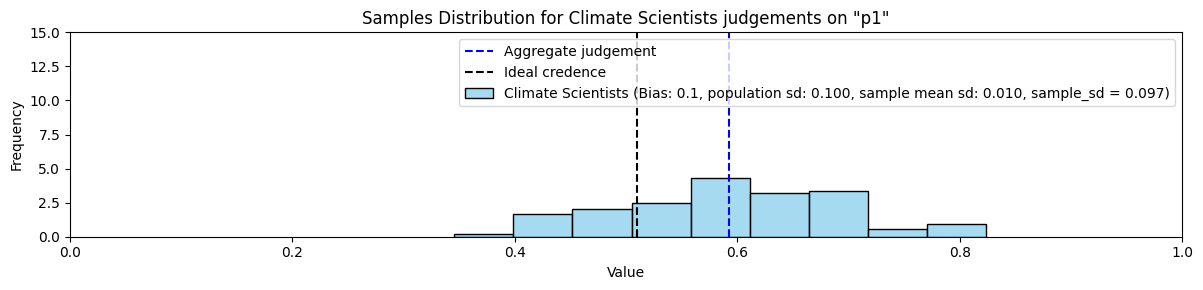

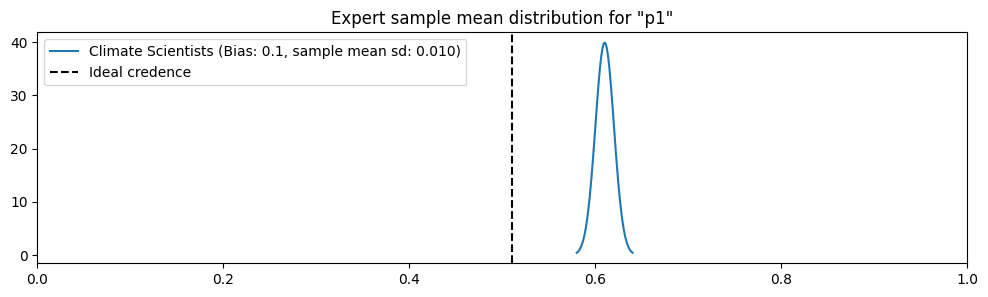

In [15]:
PLOT = True

propositions = ['p1', 
                # 'p2',
                # 'p3'
                ]
# ideal credence should be unique in each world, w. 
ideal_credence_obj = Ideal_Credences(propositions, seed=122)
ideal_credence_obj.random_generate_ideal_credences()
climate_scientists = Expert_Group(ideal_credence_obj,name = 'Climate Scientists',population_bias=0.1,population_sd=0.1,n_experts=100, plot = PLOT)
# climate_skeptics = Expert_Group(ideal_credence_obj,name = 'Climate Skeptics',population_bias=-0.2,population_sd=0.3,n_experts=50, plot = PLOT)

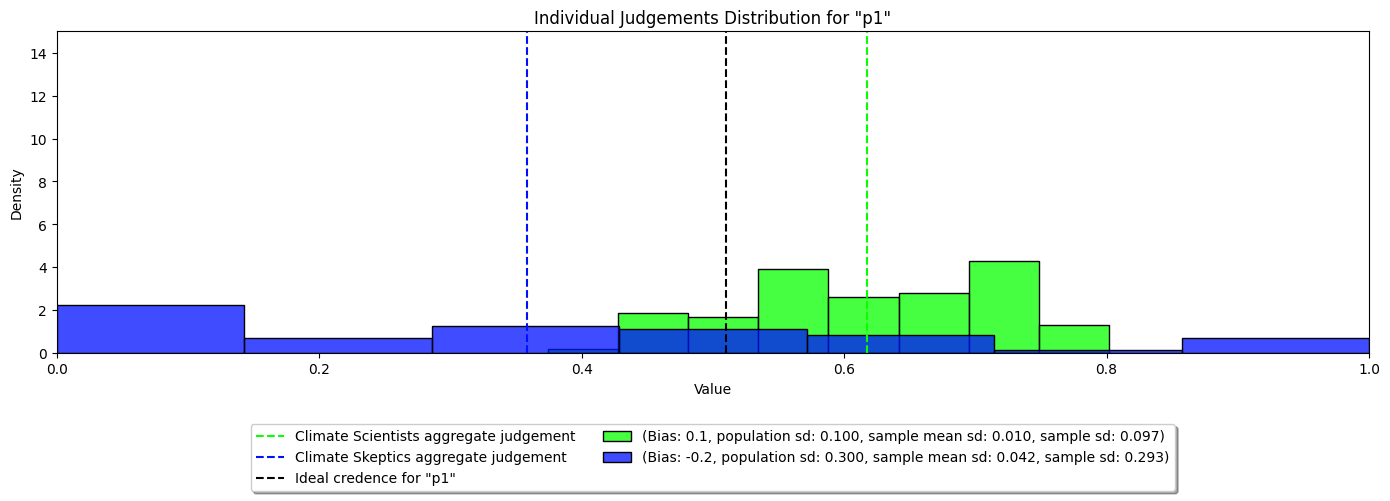

In [12]:
expert_groups = [climate_scientists
                #  ,climate_skeptics
                 ]
plot_all_individual_judgements(expert_groups)

Generating model for proposition:  p1


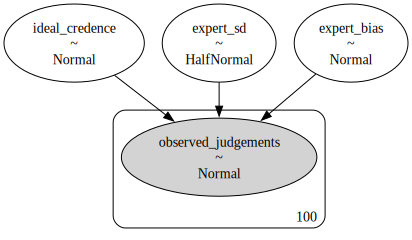

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ideal_credence, expert_bias, expert_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 223 seconds.


[Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data]

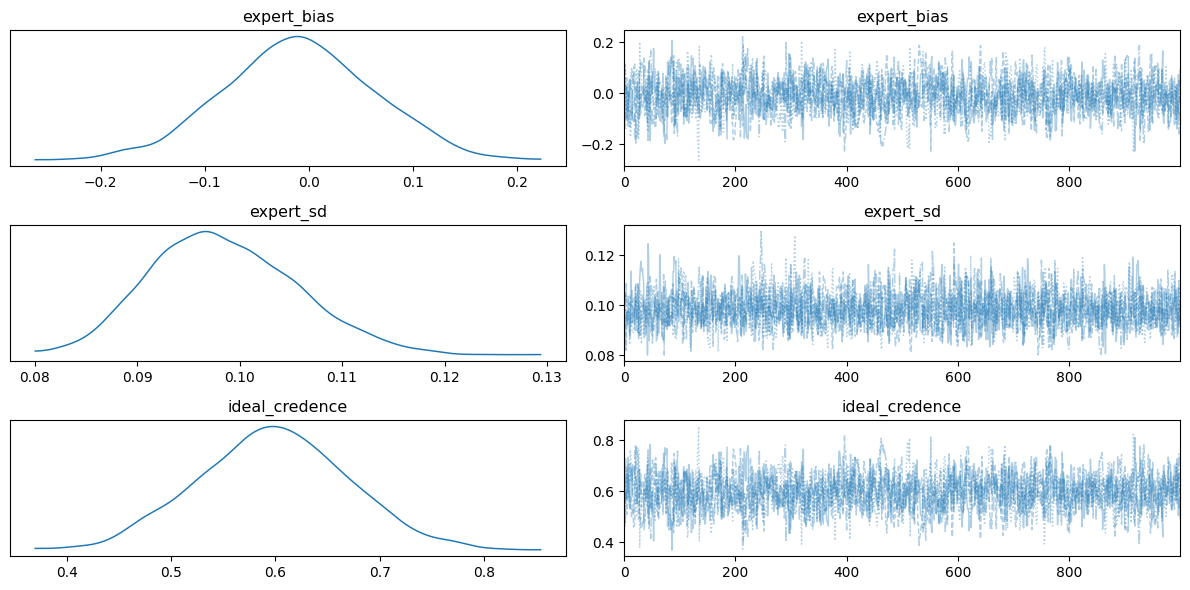

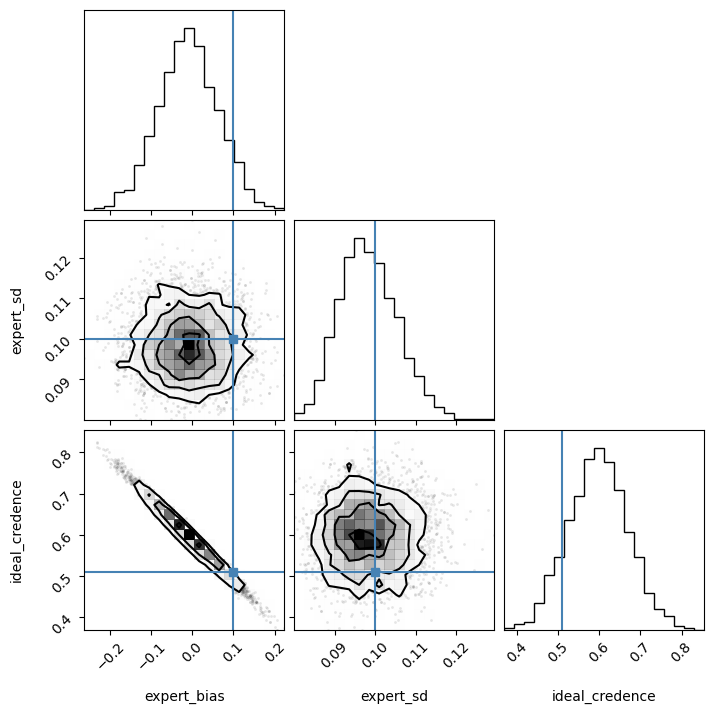

## Example: Sceptical but Open Agent
### Here we can see that the agent's priors move closer to the experts', but does not fully defer. 
### At the same time, the agent's estimate for the expert's bias is increased. 

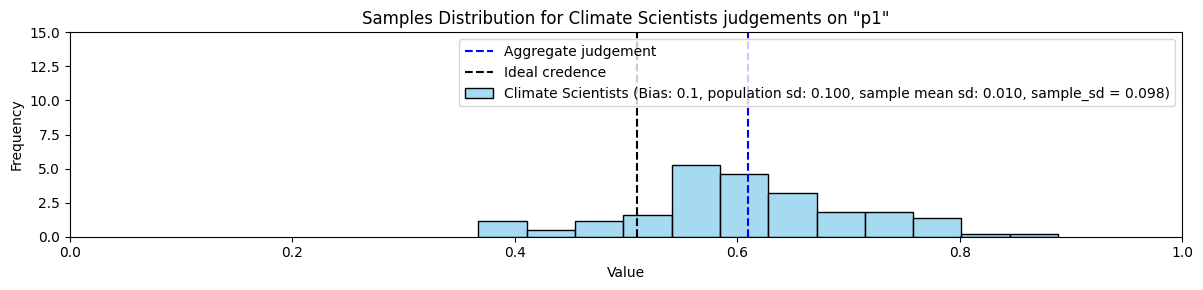

Generating model for proposition:  p1


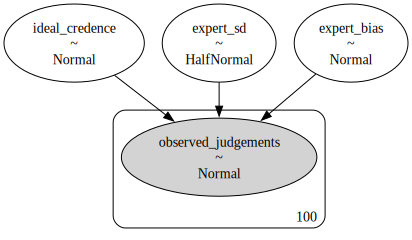

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ideal_credence, expert_bias, expert_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 730 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


[Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data]

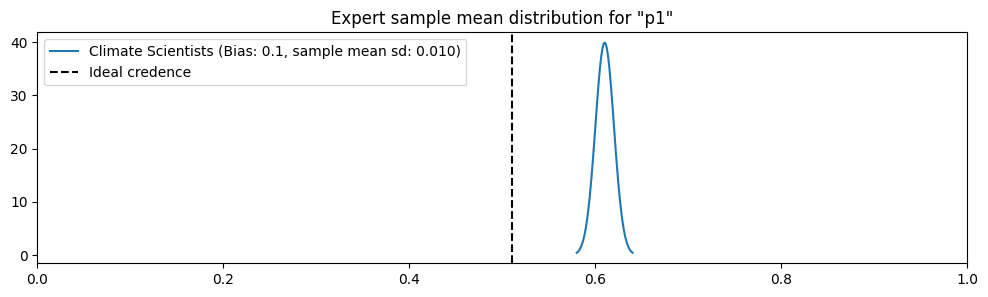

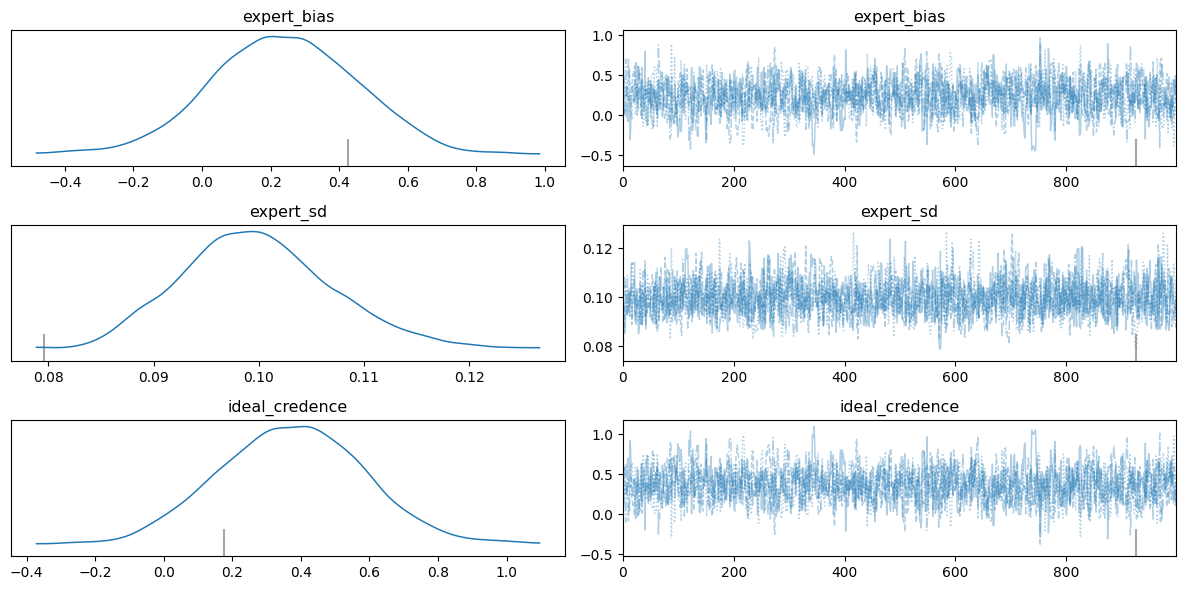

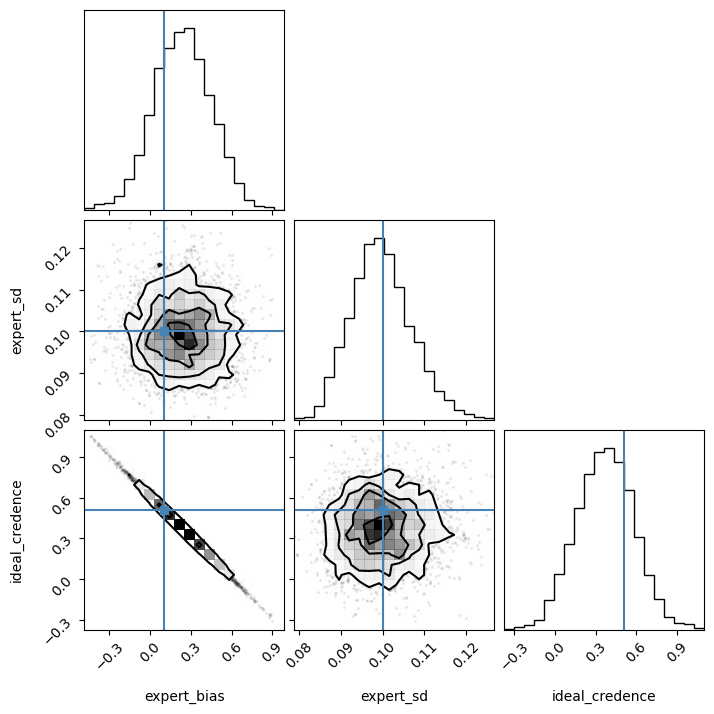

In [23]:

PLOT = True

propositions = ['p1', 
                ]
# ideal credence should be unique in each world, w. 
ideal_credence_obj = Ideal_Credences(propositions, seed=122)
ideal_credence_obj.random_generate_ideal_credences()
climate_scientists = Expert_Group(ideal_credence_obj,name = 'Climate Scientists',population_bias=0.1,population_sd=0.1,n_experts=100, plot = PLOT)

agent_1 = Bayesian_Agent(ideal_credence_obj)
agent_1.get_expert_model(climate_scientists, prior_distribution='normal', credence_prior_mu = 0.1, credence_prior_sigma = 0.3, bias_prior_mu = 0.0, bias_prior_sigma = 0.3, expert_sd_prior_sigma = 0.1)
agent_1.mcmc_get_posteriors(climate_scientists)

# Example: agent with bad priors

Generating model for proposition:  p1


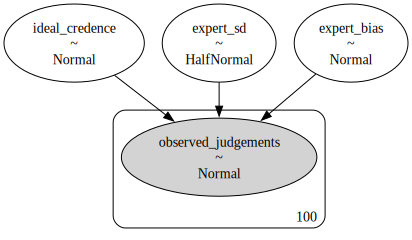

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ideal_credence, expert_bias, expert_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 249 seconds.


[Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data]

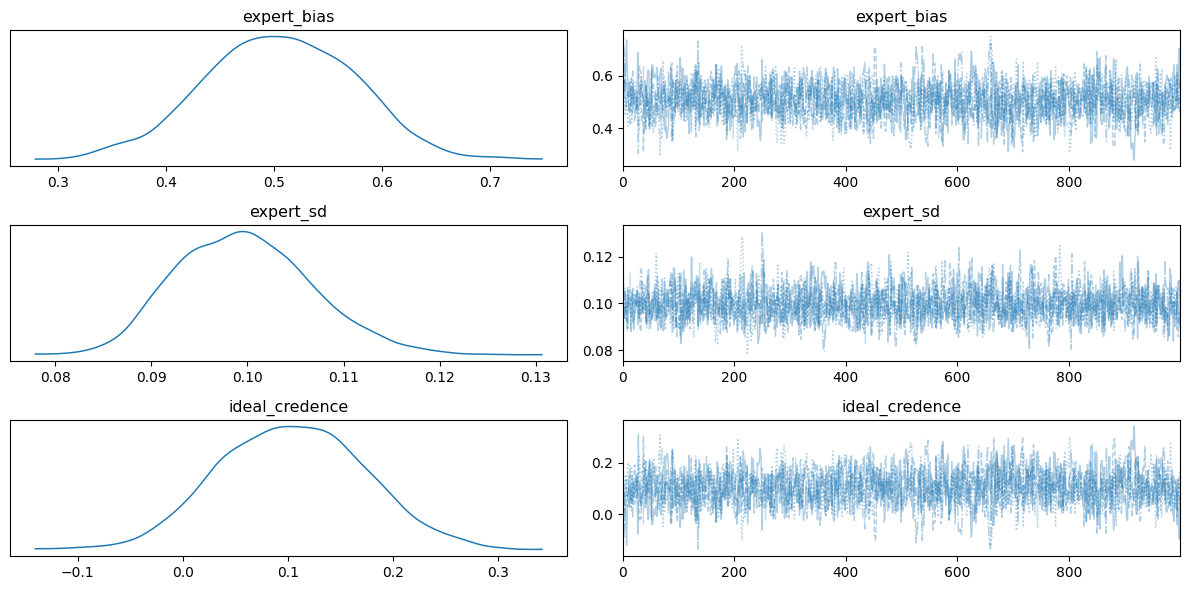

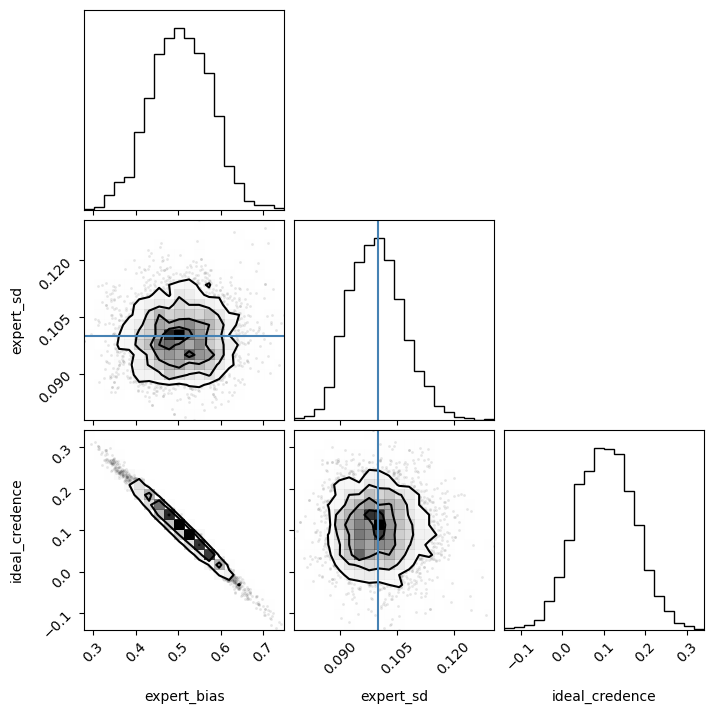

In [24]:
agent_2 = Bayesian_Agent(ideal_credence_obj)
agent_2.get_expert_model(climate_scientists, prior_distribution='normal', credence_prior_mu = 0.1, credence_prior_sigma = 0.1, bias_prior_mu = 0.5, bias_prior_sigma = 0.1, expert_sd_prior_sigma = 0.1)
agent_2.mcmc_get_posteriors(climate_scientists)

# Example: agent with good priors

Generating model for proposition:  p1


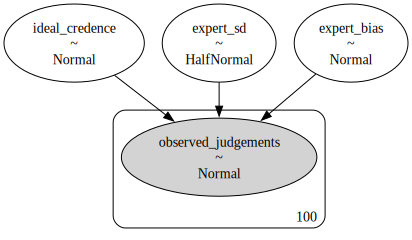

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ideal_credence, expert_bias, expert_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 320 seconds.


[Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data]

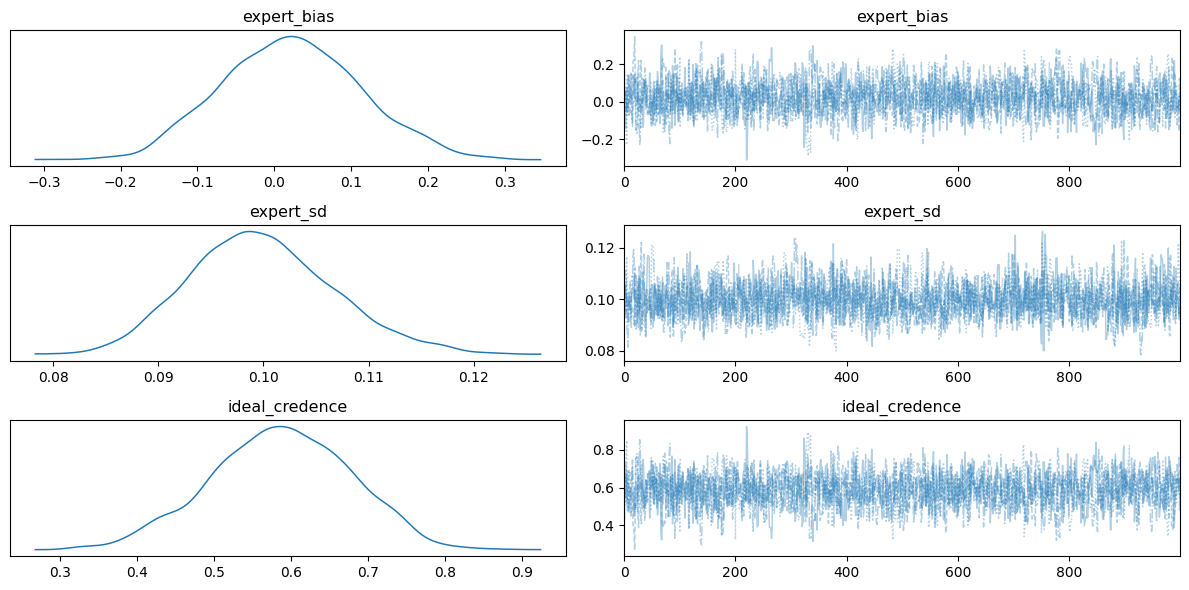

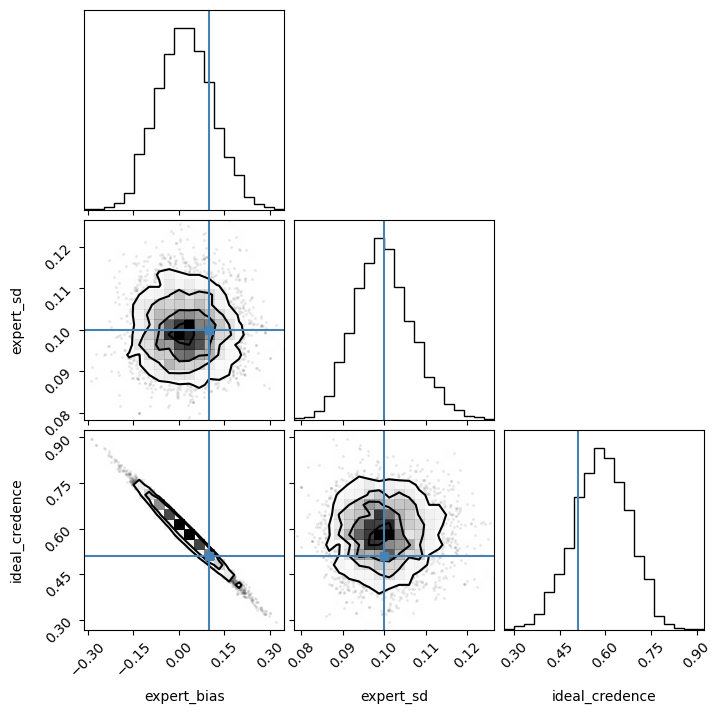

In [26]:
agent_2 = Bayesian_Agent(ideal_credence_obj)
agent_2.get_expert_model(climate_scientists, prior_distribution='normal', credence_prior_mu = 0.5, credence_prior_sigma = 0.2, bias_prior_mu = 0.0, bias_prior_sigma = 0.1, expert_sd_prior_sigma = 0.1)
agent_2.mcmc_get_posteriors(climate_scientists)

# Example: Totally Neutral Agent

Generating model for proposition:  p1


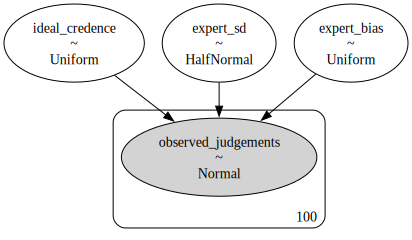

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ideal_credence, expert_bias, expert_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 676 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


[Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data]

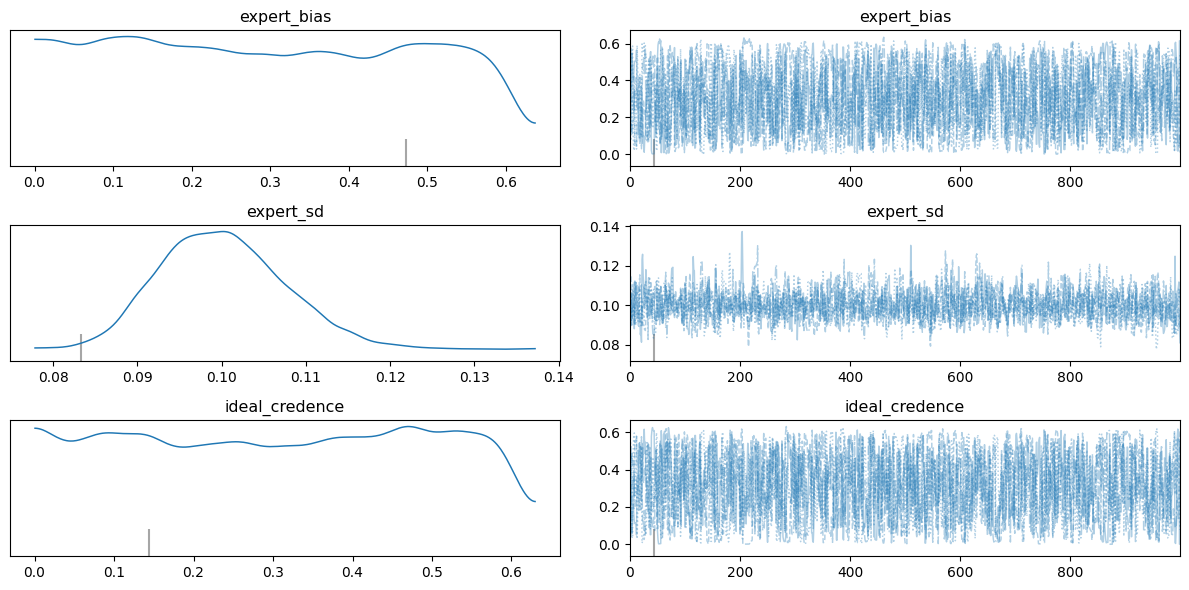

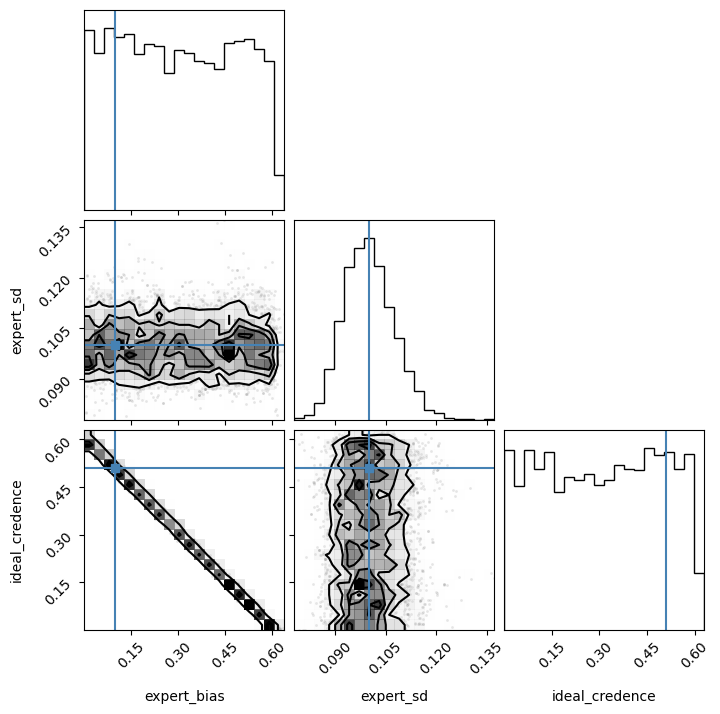

In [25]:
agent_3 = Bayesian_Agent(ideal_credence_obj)
agent_3.get_expert_model(climate_scientists, prior_distribution='uniform')
agent_3.mcmc_get_posteriors(climate_scientists)